In [37]:
import os
import trompy as tp
import numpy as np

%run "..//src//vgp_helper_fx"

In [38]:
ROOT_FOLDER = "C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\VGP2"

DATA_FOLDER = os.path.join(ROOT_FOLDER, "Processed\\s2p")
BEHAV_FOLDER = os.path.join(ROOT_FOLDER, "Bonsai\\")
METAFILE = os.path.join(ROOT_FOLDER, "Metafile_VGP2.3.xls")
rows, header = tp.metafilereader(METAFILE, sheetname="2panalysispilot")


File is excel file. Making csv metafile first


In [39]:
# Goes through metafile assembling data from s2p files where possible

cell_data={}

for row in rows:
    try:
        key=row[0]+'_'+row[1]
        animal=row[0]
        day=row[1]
        date=int(row[3])
        events=row[5]
        
        s2p_folder = os.path.join(DATA_FOLDER, "sub-{}\\ses-{}".format(animal, day))
        events_file =BEHAV_FOLDER+events
        
        
        cell_data[key] = assemble_data(s2p_folder,events_file)
        cell_data[key]['animal'] = row[0]
        cell_data[key]['diet'] = row[4]
        cell_data[key]['solution'] = row[2]
        
    except FileNotFoundError:
        print('Cannot find file for', key)
        

In [40]:
cell_data["VGP118_029"]["df_responsive"]

,responsive,activated,inhibited
pump_all,5,3,2
lick_all,10,8,2
pump_only,1,0,1
lick_only,6,5,1
both,4,3,1
neither,14,17,22


In [41]:
cols = ["animal", "diet", "solution", "lick_activated"]
df_activated = pd.DataFrame(columns=cols)

for key, d in cell_data.items():
    percent_act = d["df_responsive"].loc["lick_only", "activated"] / np.sum(d["df_responsive"].loc['pump_only':'neither',"activated"]) * 100
    data = np.array([d["animal"], d["diet"], d["solution"], percent_act])
    df_temp = pd.DataFrame({col: value for col, value in zip(cols, data)},
                          index=[key.split("_")[0]]).astype({'lick_activated':'float'})
    

    df_activated = pd.concat([df_activated, df_temp])
# df_activated.astype({'lick_activated':'float'},inplace=True)    
df_activated

,animal,diet,solution,lick_activated
VGP118,VGP118,PR,Cas,10.526316
VGP118,VGP118,PR,Malt,20.000000
VGP118,VGP118,PR,Malt,23.529412
VGP118,VGP118,PR,Cas,8.333333
VGP118,VGP118,PRNR,Malt,30.769231
VGP118,VGP118,PRNR,Malt,27.777778
VGP118,VGP118,PRNR,Cas,33.333333
VGP118,VGP118,PRNR,Cas,22.222222
VGP202,VGP202,NR,Cas,40.000000
VGP202,VGP202,NR,Malt,25.000000


In [42]:
df_pref = (df_activated.pivot_table(index=["animal", "diet"],
                         columns=["solution"],
                         values="lick_activated",
                         aggfunc="mean")
             .astype({"Cas": "float", "Malt": "float"})
#              .assign(pref=lambda df_: df_.cas / (df_.cas + df_.malt))
             .assign(pref=lambda df_: df_.Cas - df_.Malt)
            )


In [43]:
df_pref

solution           Cas       Malt       pref
animal diet                                 
VGP118 PR     9.429825  21.764706 -12.334881
       PRNR  27.777778  29.273504  -1.495726
VGP202 NR    24.347826  28.017241  -3.669415
       NRPR  17.812964  16.525097   1.287867
VGP203 PR    18.633952  16.825397   1.808555
       PRNR  17.385866  20.197947  -2.812081
VGP302 PR    47.964040  28.883023  19.081017
       PRNR  23.728814  17.241379   6.487434
VGP306 PR    11.764706  10.882353   0.882353
VGP310 NR    13.663664  36.734694 -23.071030
       NRPR  15.217391   5.000000  10.217391
VGP403 NR    15.391705  11.764706   3.626999
       NRPR  20.501931  14.514515   5.987416

In [44]:
PRs = ["PR"]
NRs = ["NR"]

(df_pref
 .droplevel(0)
 .pref
 .reset_index()
 .query("diet in @NRs")
 .mean()
#  .loc["PR"]
)



pref   -7.704482
dtype: float64

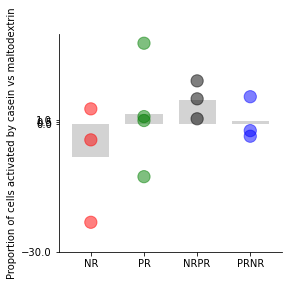

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

df = (df_pref
 .reset_index()
 .pivot_table(index="animal",
              columns="diet",
              values="pref")
#  .fillna(0)
 .assign(NR=lambda df_:df_.NR,
         PR=lambda df_: df_.PR,
         NRPR=lambda df_:df_.NRPR,
         PRNR=lambda df_:df_.PRNR)
#  .drop(columns=["NRPR", "PRNR"])
)

# print(df)

f, ax = plt.subplots(figsize=(4,4))
x = [1,2,3,4]
for row in df.iterrows():
    y = [[row[1].NR, row[1].PR],[ row[1].NRPR, row[1].PRNR]]
#     print(y)
#     ax.plot(x, y, color="grey")
    ax.scatter(x, y, s=150, color=["red", "green",'k','blue'], zorder=20, alpha=0.5)

  
    
ax.bar(x, [df.NR.mean(), df.PR.mean(), df.NRPR.mean(), df.PRNR.mean()], width=0.7, zorder=-1, color="lightgrey")
    
ax.set_ylabel("Proportion of cells activated by casein vs maltodextrin")
ax.set_yticks([-30,0, 0.5, 1.0])

ax.set_xticks([1,2,3,4])
ax.set_xticklabels(["NR", "PR", 'NRPR','PRNR'])
ax.set_xlim([0.4,4.6])

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

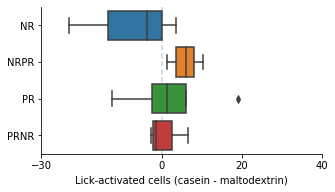

In [46]:
f, ax = plt.subplots(figsize=(6,3),
                     gridspec_kw={"left": 0.25, "bottom": 0.2})

sns.boxplot(data=df, orient="h", ax=ax)

ax.set_ylabel("")
# ax.set_yticklabels(["Non-restricted", "Protein-restricted"])
ax.set_xticks([-30, 0, 20, 40])
ax.set_xlabel("Lick-activated cells (casein - maltodextrin)")

ax.axvline(0, color="lightgrey", linestyle="--", zorder=-1)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# f.savefig("..//output//grouped_casmalt_diff.png")

In [11]:
sns.boxplot?

Signature:
sns.boxplot(
    *,
    x=None,
    y=None,
    hue=None,
    data=None,
    order=None,
    hue_order=None,
    orient=None,
    color=None,
    palette=None,
    saturation=0.75,
    width=0.8,
    dodge=True,
    fliersize=5,
    linewidth=None,
    whis=1.5,
    ax=None,
    **kwargs,
)
Docstring:
Draw a box plot to show distributions with respect to categories.

A box plot (or box-and-whisker plot) shows the distribution of quantitative
data in a way that facilitates comparisons between variables or across
levels of a categorical variable. The box shows the quartiles of the
dataset while the whiskers extend to show the rest of the distribution,
except for points that are determined to be "outliers" using a method
that is a function of the inter-quartile range.


Input data can be passed in a variety of formats, including:

- Vectors of data represented as lists, numpy arrays, or pandas Series
  objects passed directly to the ``x``, ``y``, and/or ``hue`` parameters.
- A 